In [1]:
import numpy as np
import numpy.random as rand
import matplotlib.pyplot as plt

## Thrust Data

In [2]:
thrustFromFile = np.genfromtxt('./AeroTech_L1520T.csv',delimiter=',')

In [3]:
thrust = np.insert(thrustFromFile,0,[0,0],axis=0)

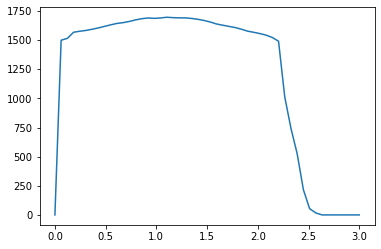

In [4]:
plt.plot(np.linspace(0,3),np.interp(np.linspace(0,3),thrust[:,0],thrust[:,1]));

In [455]:
#returns thrust force given a certain time in Newtons (N)
def thrustFunc(t):
    return np.interp(t,thrust[:,0],thrust[:,1])

burnoutTime = 2.5
def massFunc(t):
    if(t<burnoutTime):
        return 12.284+3.62*(1-t/burnoutTime)
    else:
        return 12.284

#BAAAADDDD
#Please do better
def dragCoeffFunc(totalVel):
    if(totalVel<45):
        return .435-(.435-.335)/45*totalVel
    else:
        return (.335*(210-totalVel)+.422*(totalVel-45))/(210-45)
    
    
#returns an approximation for the density of air at a given altitutde
def rho(altitude):
    rho0 = 1.225 #kg/m^3
    Hn = 10.4*10**3 #meters
    return rho0*np.exp(-altitude/Hn)

## Simulation settings

In [456]:
dt=0.001
tInitial = 0
tFinal = 100
time = np.arange(tInitial,tFinal,dt)

In [457]:
mass = 12.2284 #kg
gravityForce = np.array([0,0,-9.81])*mass
Area = 0.0232
parachuteDragCoefficient = 10

In [458]:
#given the rockets position, velocity, drag Coefficient, and time, return how the velocity and position change
def derivative(position, velocity,dragCoefficient, t):
    #determine which way the rocket is pointing
    direction = velocity/(np.linalg.norm(velocity)+10**-9)
    
    #if on rail, launch angle is set
    if(position[2]<1):
        direction = np.array([0,np.sin(0.0873),np.cos(0.0873)])
    
    #wind force - random gusts of wind pushing the rocket on the way up
    #wind mostly blows side to side and not up and down (I think?)
    windforce = windFunc(t)*np.array([rand.normal(loc=1,scale=windxStdDev),rand.normal(loc=1,scale=windyStdDev),rand.normal(loc=windzRatio,scale=windzStdDev)])
    
    sumForces = gravityForce + (thrustFunc(t) - 1/2*Area*rho(position[2])*np.linalg.norm(velocity)**2*dragCoefficient)*direction+windforce
    
    return [sumForces/massFunc(t),velocity + sumForces/massFunc(t)*dt]
    
#function to perform integration step
#helpful to change out integration under the hood without needing to clutter main loop
def quadrature(position,velocity,dragCoefficient, t):
    
    #Heun's method
#     motion = derivative(position, velocity, dragCoefficient,t)
#     velocityGuess = velocity + motion[0]*dt
#     positionGuess = position + motion[1]*dt
    
#     motionUpdate = derivative(positionGuess,velocityGuess,dragCoefficient,t+dt)
    
#     velocityNext = velocity + dt/2*(motion[0]+motionUpdate[0])
#     positionNext = position + dt/2*(motion[1]+motionUpdate[1]) 
#     accelerationCurrent = 1/2*(motion[0]+motionUpdate[0])

    #Runge-Kutta method
    k1 = derivative(position, velocity, dragCoefficient,t)
    k2 = derivative(position + dt*k1[1]/2,velocity + dt*k1[0]/2,dragCoefficient,t+dt/2)
    k3 = derivative(position + dt*k2[1]/2,velocity + dt*k2[0]/2,dragCoefficient,t+dt/2)
    k4 = derivative(position + dt*k3[1],velocity + dt*k3[0],dragCoefficient,t+dt)
    
    velocityNext = velocity + dt/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    positionNext = position + dt/6*(k1[1]+2*k2[1]+2*k3[1]+k4[1])
    accelerationCurrent = 1/6*(k1[0]+2*k2[0]+2*k3[0]+k4[0])
    
    return positionNext, velocityNext, accelerationCurrent

## VLT

In [459]:
initialVel = 270
targetAlt = 1584
def velocityProfile(alt):
    return initialVel/np.sqrt(targetAlt)*np.sqrt(targetAlt-alt)

altitudes = np.linspace(0,targetAlt,100)

velocityLookupTableBase = np.array([altitudes,velocityProfile(altitudes)])
velocityLookupTable = np.transpose(np.genfromtxt('./DragVLT.csv',delimiter=','))
velocityLookupTable[1,-1] = 0
accelLookupTable = np.transpose(np.genfromtxt('./ALT.csv',delimiter=','))

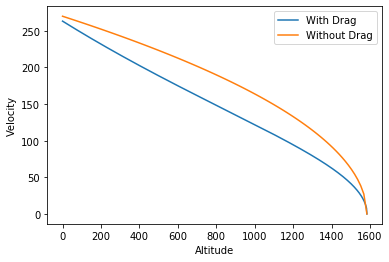

In [460]:
plt.plot(velocityLookupTable[0],velocityLookupTable[1]);
plt.plot(velocityLookupTableBase[0],velocityLookupTableBase[1]);
plt.legend(['With Drag','Without Drag']);
plt.xlabel('Altitude');
plt.ylabel('Velocity');

## Wind Settings

In [461]:
#function that kinda simulates random winds on the way up
def windFunc(time):
    return 3*(np.sin(time/2)+np.cos(time/20))

windxStdDev = .5
windyStdDev = .5
windzStdDev = .5
#ratio of z wind to xy wind
windzRatio = .5

## Controller Settings

In [462]:
controlFrequency= 32 #Hz
controldt = 1/controlFrequency
controlTicks = int(controldt//dt) #in number of ticks (if dt = 0.001, then this represents ms)
rocketDrag = 0.45
airbrakesMaxDrag = 0.25

def errorDecayFunc(alt):
    errorDecayTable = np.array([[targetAlt/4, targetAlt/2,7/8*targetAlt, 2*targetAlt],
                                [     40    ,   20      ,    10,           0]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((errorDecayTable[0]-alt)>0)
    return errorDecayTable[1,index]

def getMaxError(alt):
    maxErrorTable = np.array([[2/8*targetAlt,6/8*targetAlt, 2*targetAlt],
                                [    30      ,    10,           3]])
    #find the index of the first altitude entry which is greater than the current altitude
    index = np.argmax((maxErrorTable[0]-alt)>0)
    return maxErrorTable[1,index]

def calculateError(position,velocity):
    altitude = position[2]
    velocityError = velocity[2] - float(np.interp(altitude, velocityLookupTable[0],velocityLookupTable[1]))
    return velocityError

def calculateAccelError(position,acceleration):
    altitude = position[2]
    accelerationError = acceleration[2] - np.interp(altitude, accelLookupTable[0],accelLookupTable[1])
    return accelerationError

## Airbrake Deployment

In [463]:
secondsPerDegree = 1/2*0.09/60 #number of seconds per degree 

def angleToDrag(profile):
    return profile/90*airbrakesMaxDrag

def deploymentProfile(currentDegrees, TargetDegrees):
    if currentDegrees < TargetDegrees:
        profile = np.linspace(currentDegrees,currentDegrees+controlTicks*dt/secondsPerDegree,num=controlTicks+1)
        profile[profile>TargetDegrees]=TargetDegrees
    else:
        profile = np.linspace(currentDegrees,currentDegrees-controlTicks*dt/secondsPerDegree,num=controlTicks+1)
        profile[profile<TargetDegrees]=TargetDegrees
    return profile

## Kalman Filter settings

In [464]:
#kalman step size
sampleFrequency = 100 #Hz
kdt = 1/sampleFrequency
#for loop
kalmanTicks = int(kdt//dt)

#state Vector
#X = [[x],[y],[z],[vx],[vy],[vz],[ax],[ay],[az]]

#state transition matrix
Fkalman = np.array([[1,0,0,kdt,  0,  0,1/2*kdt**2,         0,         0],
                    [0,1,0,  0,kdt,  0,         0,1/2*kdt**2,         0],
                    [0,0,1,  0,  0,kdt,         0,         0,1/2*kdt**2],
                    [0,0,0,  1,  0,  0,       kdt,         0,         0],
                    [0,0,0,  0,  1,  0,         0,       kdt,         0],
                    [0,0,0,  0,  0,  1,         0,         0,       kdt],
                    [0,0,0,  0,  0,  0,         1,         0,         0],
                    [0,0,0,  0,  0,  0,         0,         1,         0],
                    [0,0,0,  0,  0,  0,         0,         0,         1]])

#Input translation matrix
#take input accelerations from rocket thrust and turn that into state matrix adjustment
Gkalman = np.array([[1/2*kdt**2,0,0],
                    [0,1/2*kdt**2,0],
                    [0,0,1/2*kdt**2],
                    [kdt,0,0],
                    [0,kdt,0],
                    [0,0,kdt],
                    [1,0,0],
                    [0,1,0],
                    [0,0,1]])

#observation model
#converts state vector to equivalent oberservations 
#we get the altitude from the altimeter and the acceleration data from IMU
Hkalman = np.array([[0,0,1,0,0,0,0,0,0],
                    [0,0,0,0,0,0,1,0,0],
                    [0,0,0,0,0,0,0,1,0],
                    [0,0,0,0,0,0,0,0,1]])

#estimate covariance
#should be zero to start because we know exactly where the rocket starts
#however, setting it to this makes the kalman algorithm slow to adjust to the rapid start in motion
Pkalman = np.zeros((9,9))

#process noise
processVar=(.5)**2
Qkalman = np.matmul(Gkalman,np.transpose(Gkalman))*processVar

#measurement covariance
altimeterVar = (.1)**2
accelXVar = (2)**2
accelYVar = (2)**2
accelZVar = (2)**2

#measurement covariance matrix
Rkalman = np.array([[altimeterVar,0,0,0],
                    [0,           accelXVar,0,0],
                    [0,           0,accelYVar,0],
                    [0,           0,0,accelZVar]])

#measurement drift settings
accelXdrift = 1*kdt #m/s
accelYdrift = 1*kdt #m/s
accelZdrift = 1*kdt #m/s

## Integration Loop

In [500]:
time = np.arange(tInitial,tFinal,dt)
positions = np.zeros((len(time),3)); # x,y,z
velocities = np.zeros((len(time),3)); # vx,vy,vz
accelerations = np.zeros((len(time),3)); #ax,ay,az
dragCoefficient  = np.full((len(time)),rocketDrag);
airbrakeDeploymentAngle  = np.full((len(time)),0);
errorArray = np.full((len(time)),0.0);
stateVectors = np.zeros((len(time),9));
measurements = np.zeros((len(time),4))
Pkalman = np.eye(9)*10
innovation = 0
innovationCov = 0

integralError = 0;
#used to turn off controller after apogee
runControl = False;
parachuteDeployed = False;

#used to truncate data
finalTick = 0

for i in range(len(time)-1):
    
    #see quadrature equation for how integration occurs
    positions[i+1], velocities[i+1], accelerations[i]  = quadrature(positions[i],velocities[i],dragCoefficient[i],time[i]) 
    
    #ends simulation when rocket hits ground
    if (positions[i,2]<=0) and (time[i]>1):
        finalTick = i
        break
    
    #Kalman filter attempt
    if((i%kalmanTicks==0) and (i>0)):
        #takes the current altitude and x,y,z accelerations and adds defined noise to those values
        #these values become the measurement that is fed into the kalman filter
        #the first step of the kalman filter is to predict what the next state should be based on the previous
        #step and the state transition matrix (essentially just forward integration)
        #it then converts this into the measurement space with Hkalman and comapres this with actual measured values
        #this difference is called the innovation
        #the kalman filter then corrects its guess at the next state by calculating the optimal gain Kkalman
        #Kkalman is determined by comparing the estimate covariance (how confident it is in the current estimate) and 
        #the innovation covariance (how confident it is in the measurement)
        
        #take measurement


        measurements[i:i+kalmanTicks] = [positions[i,2]+rand.normal(0,np.sqrt(altimeterVar)),
                                         accelerations[i,0]+rand.normal(accelXdrift,np.sqrt(accelXVar)),
                                         accelerations[i,1]+rand.normal(accelYdrift,np.sqrt(accelYVar)),
                                         accelerations[i,2]+rand.normal(accelZdrift,np.sqrt(accelZVar))]
        
        ###Predict Step        
        stateVectors[i:i+kalmanTicks] = np.matmul(Fkalman, stateVectors[i-kalmanTicks])
        #Potentially add step that increases Qkalman during motor burn, then decreases it
        Pkalman = np.matmul(Fkalman,np.matmul(Pkalman,np.transpose(Fkalman))) + Qkalman
        
        ###Update Step
        innovation = measurements[i] - np.matmul(Hkalman,stateVectors[i])
        
        innovationCov = np.matmul(Hkalman,np.matmul(Pkalman,np.transpose(Hkalman)))+Rkalman
        
        #optimal Kalman Gain
        Kkalman = np.matmul(Pkalman,np.matmul(np.transpose(Hkalman),np.linalg.inv(innovationCov)))
        #print(np.linalg.norm(Kkalman))
        
        #update state estimate
        stateVectors[i:i+kalmanTicks] = stateVectors[i] + np.matmul(Kkalman,innovation)
        #update estimate covariance
        Pkalman = np.matmul((np.eye(9)-np.matmul(Kkalman,Hkalman)),Pkalman)
    
    #turn on controller when motor burns out
    if((((stateVectors[i,8]<= -15) and (runControl==False)) and parachuteDeployed==False) and time[i]>1):
        print("Controller turned on at "+ str(time[i]))
        runControl = True
        
    #deploy parachute when rocket hits apogee
    if ((stateVectors[i,5]<=0) and (time[i]>1)) and runControl == True:
        runControl = False
        parachuteDeployed = True
        print("Controller turned off at "+ str(time[i]))
        dragCoefficient[i:] = parachuteDragCoefficient
        
    #control algorithim, evaluate periodically (250 ticks or 250 m/s)
    if(i%controlTicks==0) and runControl:
        #control algorithm outline
        # - determine how off the rocket velocity is from VLT given altitude
        #     - clip this value so that it less than the max allowable
        # - add the current error to the integral error term
        #     - subtract error decay given altitude
        #     - integral error penalizes being wrong for long period of time
        #     - have decay so that it doesn't always blow up to inf + allows me to make controller more strict over time
        # - control parameter is determined by summing current error and integral error and dividing by max error
        #     - airbrakes are then deployed such that that percentage of the drag coefficient is deployed
        #     - TODO: create transfer function from control parameter to deployment percentage
        #         - assume to be linear initially
        
        maxError = getMaxError(stateVectors[i,2])
        #calculate how off the velocity is from desired
        errorArray[i+controlTicks] = calculateError(stateVectors[i,0:3],stateVectors[i,3:6])
        
        #add this error to integralError
        #This will take account of continually wrong velocities and give it a boost
        #errorDecay helps this term not just grow over time
        #effectively means it will help velocity get within errorDecay of desiredVelocity
        
        integralError += 1/controlFrequency*(errorArray[i] - errorDecayFunc(positions[i,2]))
        #integralError = 1/controlFrequency*np.sum(errorArray[i-64*controlTicks:i+controlTicks])/65
        #integralError = stateVectors[i,2]-np.interp(stateVectors[i,5], np.flip(velocityLookupTable[1]),np.flip(velocityLookupTable[0]))
        
        #if within a close value of the target vel, set the integral error to zero so that we don't overshoot
        if errorArray[i]<.1:
            integralError = 0
        
        if integralError < 0:
            integralError = 0
        
        #errorDerivative = errorArray[i]-errorArray[i-controlTicks]
        errorDerivative = controldt * calculateAccelError(stateVectors[i,0:3],stateVectors[i,6:9])
        
        print("Alt: "+str(stateVectors[i,2]/targetAlt), end='   ')
        print("Error: "+ str(errorArray[i]),end = '   ')
        print("INT Error: "+str(integralError),end='   ')
        print("DER Error "+ str(errorDerivative))
        
        #calculate how much control we want to exert as a function of the maximum
        control = (1*errorArray[i]+.2*integralError+2*errorDerivative)/maxError
        
        #if hit target, stop controlling
        if errorArray[i]<=.01:
            control = 0
        
        #if control is greater than 1, bring it down
        if control >1:
            control = 1
        if control <0:
            control = 0
        
        targetAngle = 90*control
        
        airbrakeDeploymentAngle[i:i+controlTicks+1] = deploymentProfile(airbrakeDeploymentAngle[i-1],targetAngle)
        
        #adjust the drag coefficient for the next section of the simulation
        #MOVE OUT OF CONTROL LOOP
        totalVelocity = np.linalg.norm(velocities[i])
        dragCoefficient[i:i+controlTicks+1] = dragCoeffFunc(totalVelocity)+angleToDrag(airbrakeDeploymentAngle[i:i+controlTicks+1])
    
        
time = time[:finalTick]
measurements = measurements[:finalTick]
positions = positions[:finalTick]
velocities = velocities[:finalTick]
accelerations = accelerations[:finalTick]
stateVectors = stateVectors[:finalTick]
dragCoefficient = dragCoefficient[:finalTick]
airbrakeDeploymentAngle = airbrakeDeploymentAngle[:finalTick]

Controller turned on at 2.49
Alt: 0.19122180879990136   Error: 0.0   INT Error: 0   DER Error 0.2761055434647769
Alt: 0.19538806832707994   Error: 2.6841496643719154   INT Error: 0   DER Error 0.1872856198160101
Alt: 0.19952716424045494   Error: 2.9216262120853287   INT Error: 0   DER Error 0.07096977160143025
Alt: 0.20366154086798308   Error: 2.9775310099664978   INT Error: 0   DER Error -0.0025271752529433256
Alt: 0.20777489239428631   Error: 3.0524978481939513   INT Error: 0   DER Error -0.06672848273343901
Alt: 0.21185433131676001   Error: 3.0463967969446344   INT Error: 0   DER Error -0.07316594229430717
Alt: 0.2159217075499703   Error: 2.990495823637417   INT Error: 0   DER Error -0.08320272338419143
Alt: 0.2199564929399724   Error: 2.9567107902875307   INT Error: 0   DER Error -0.10179388028015102
Alt: 0.22398689940659566   Error: 2.826975320497098   INT Error: 0   DER Error -0.0833777556876465
Alt: 0.22932984823265995   Error: 2.8220656498361905   INT Error: 0   DER Error -0.06

Alt: 0.5179840102257892   Error: 0.9968018411191792   INT Error: 0   DER Error -0.028064250646168243
Alt: 0.5207612528535176   Error: 0.8642648198834308   INT Error: 0   DER Error -0.01033256328305121
Alt: 0.5235187650546652   Error: 0.8989903058662776   INT Error: 0   DER Error -0.011472726102503938
Alt: 0.5262580834461065   Error: 0.8738945442015904   INT Error: 0   DER Error 0.009235542306829547
Alt: 0.5289988617006872   Error: 0.848651648010474   INT Error: 0   DER Error 0.01753930904053491
Alt: 0.5317200574216263   Error: 0.8883863796068283   INT Error: 0   DER Error 0.013711474423162118
Alt: 0.5353487145571894   Error: 0.8685304265457034   INT Error: 0   DER Error 0.00854944939511737
Alt: 0.5380518147448745   Error: 0.9180402024708201   INT Error: 0   DER Error 0.014603807753639675
Alt: 0.5407415504531732   Error: 0.9394181741182024   INT Error: 0   DER Error 0.012478227431125255
Alt: 0.5434354095808644   Error: 0.9479700270285889   INT Error: 0   DER Error 0.020358777186566424
A

Alt: 0.7436605143613412   Error: 1.3552900098198393   INT Error: 0   DER Error 0.00042766158287022016
Alt: 0.7461477663283446   Error: 1.4020631775030665   INT Error: 0   DER Error -0.03146999882693169
Alt: 0.7480043643019256   Error: 1.3552866097811602   INT Error: 0   DER Error -0.008524560787596502
Alt: 0.7498681469981285   Error: 1.364454215948271   INT Error: 0   DER Error -0.02434318271234287
Alt: 0.7517239607151547   Error: 1.399745541072491   INT Error: 0   DER Error -0.01887257979881829
Alt: 0.7535639148131574   Error: 1.4510648684709508   INT Error: 0   DER Error 0.02700356283900962
Alt: 0.7554092224850495   Error: 1.5282950835867979   INT Error: 0   DER Error 0.012026297548166975
Alt: 0.7572382709623715   Error: 1.6142110222339596   INT Error: 0   DER Error -0.020933466314906946
Alt: 0.7590556987732037   Error: 1.6130837063510057   INT Error: 0   DER Error -0.05117088278772003
Alt: 0.7608667546455287   Error: 1.5680540463886246   INT Error: 0   DER Error -0.08819597215152791

Alt: 0.8950737180968634   Error: 0.9737020274724415   INT Error: 0.5246728022580416   DER Error -0.02493602311156995
Alt: 0.8962009222785428   Error: 0.9264484021490205   INT Error: 0.5536243148251985   DER Error -0.012993539252383002
Alt: 0.8973355828480624   Error: 0.8683087350087746   INT Error: 0.5807589627942227   DER Error 0.006366563766457001
Alt: 0.8988386398644016   Error: 0.9180205693680534   INT Error: 0.6094471055869743   DER Error -0.004065642827418781
Alt: 0.899952284867204   Error: 0.9503420210638467   INT Error: 0.6391452937452196   DER Error 0.001056052372346017
Alt: 0.9010601291096795   Error: 0.9483509388962332   INT Error: 0.6687812605857268   DER Error -0.02143080705105599
Alt: 0.9021706966110893   Error: 0.9097370344725562   INT Error: 0.6972105429129942   DER Error -0.03260641726578134
Alt: 0.9032623917080385   Error: 0.9198067796422436   INT Error: 0.7259545047768143   DER Error -0.0028781237069001042
Alt: 0.9043504074965134   Error: 0.9154888931251861   INT Err

Alt: 0.9795434723150734   Error: 1.8498566873562439   INT Error: 4.283395740674767   DER Error 0.005946625456883348
Alt: 0.9800663063365342   Error: 1.869901857284244   INT Error: 4.3418301737149   DER Error 0.016709150915795168
Alt: 0.9805807404874595   Error: 1.9258721748174956   INT Error: 4.402013679177947   DER Error 0.004751335701089265
Alt: 0.9810841041504804   Error: 1.9437526408402448   INT Error: 4.462755949204205   DER Error -0.012884075308445597
Alt: 0.9817371500764422   Error: 1.9077182621058917   INT Error: 4.522372144895014   DER Error -0.000921481357893772
Alt: 0.9822318197800045   Error: 1.872615761479377   INT Error: 4.580891387441245   DER Error -0.01956193887170743
Alt: 0.9827205177916487   Error: 1.8754379301260933   INT Error: 4.639498822757685   DER Error 0.0012117466732926019
Alt: 0.9832126909052035   Error: 1.9261646344547003   INT Error: 4.699691467584394   DER Error -0.01025918849108931
Alt: 0.9836848561742102   Error: 1.9908308366961656   INT Error: 4.761904

## Plots

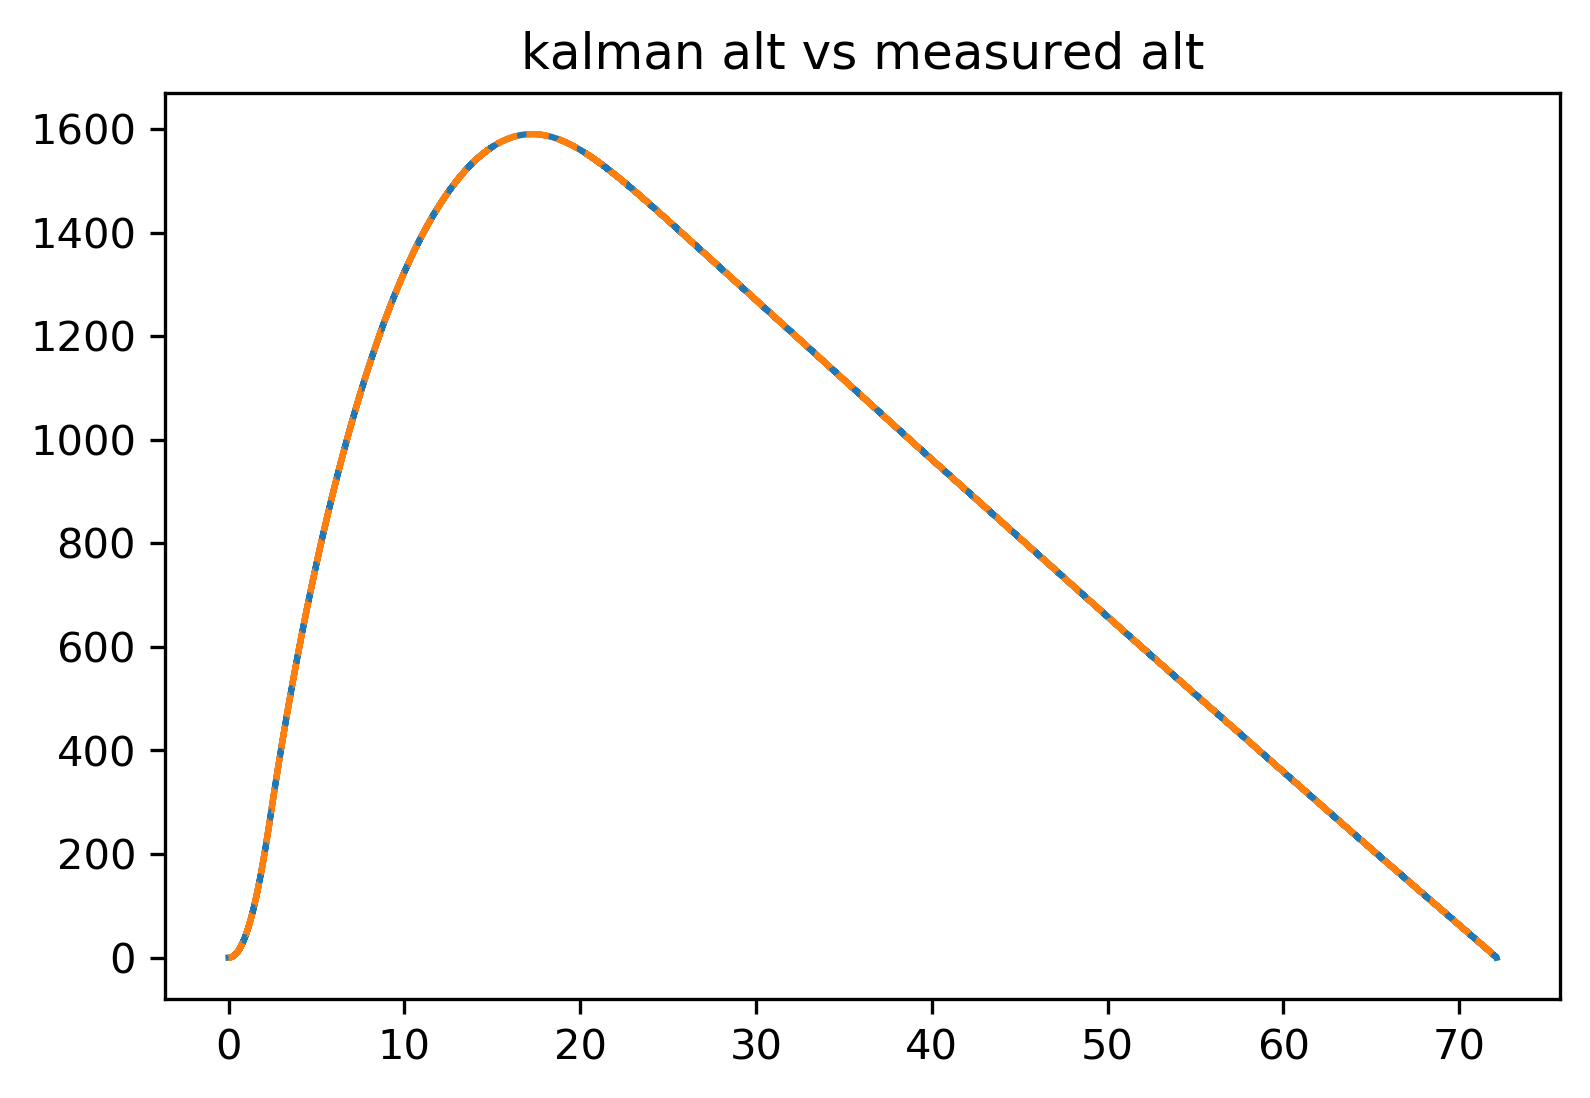

In [501]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,2])
plt.plot(time,measurements[:,0],'--');
plt.title('kalman alt vs measured alt');
plt.gcf().set_facecolor('white')

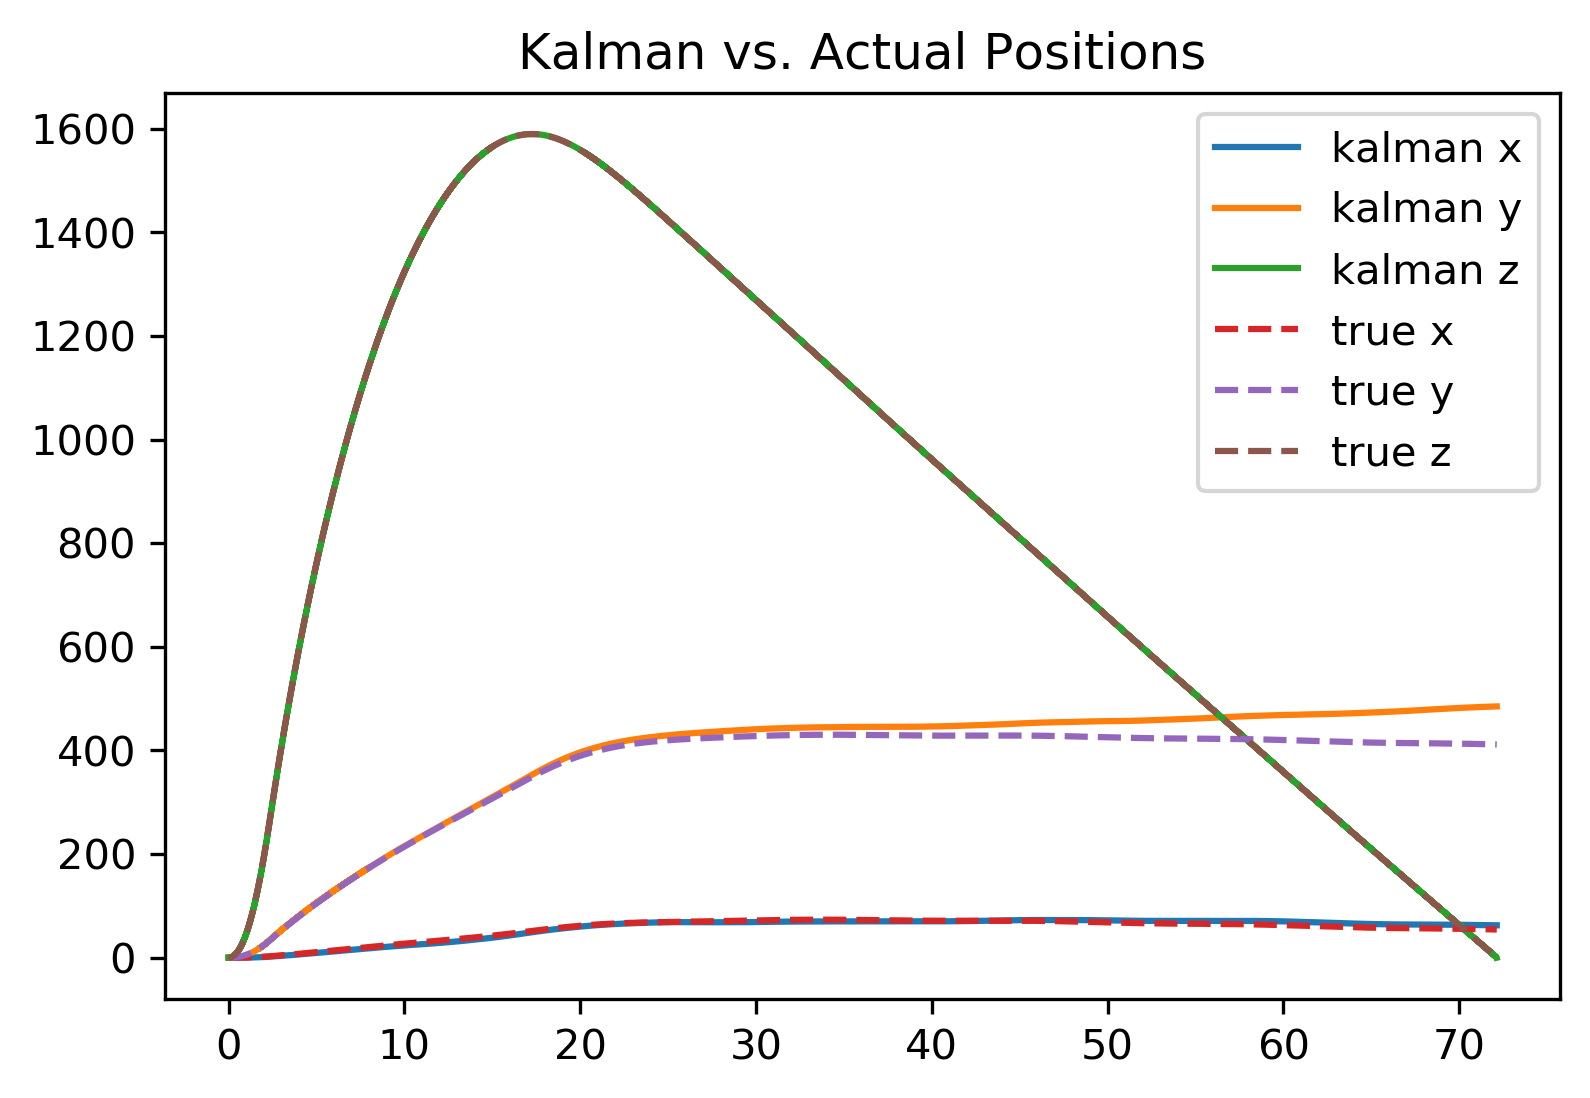

In [502]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,0:3]);
plt.plot(time,positions,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. Actual Positions');
plt.gcf().set_facecolor('white')

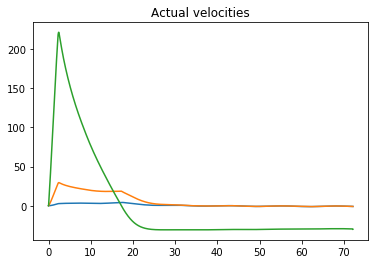

In [503]:
plt.plot(time,velocities);
plt.title('Actual velocities');
plt.gcf().set_facecolor('white')

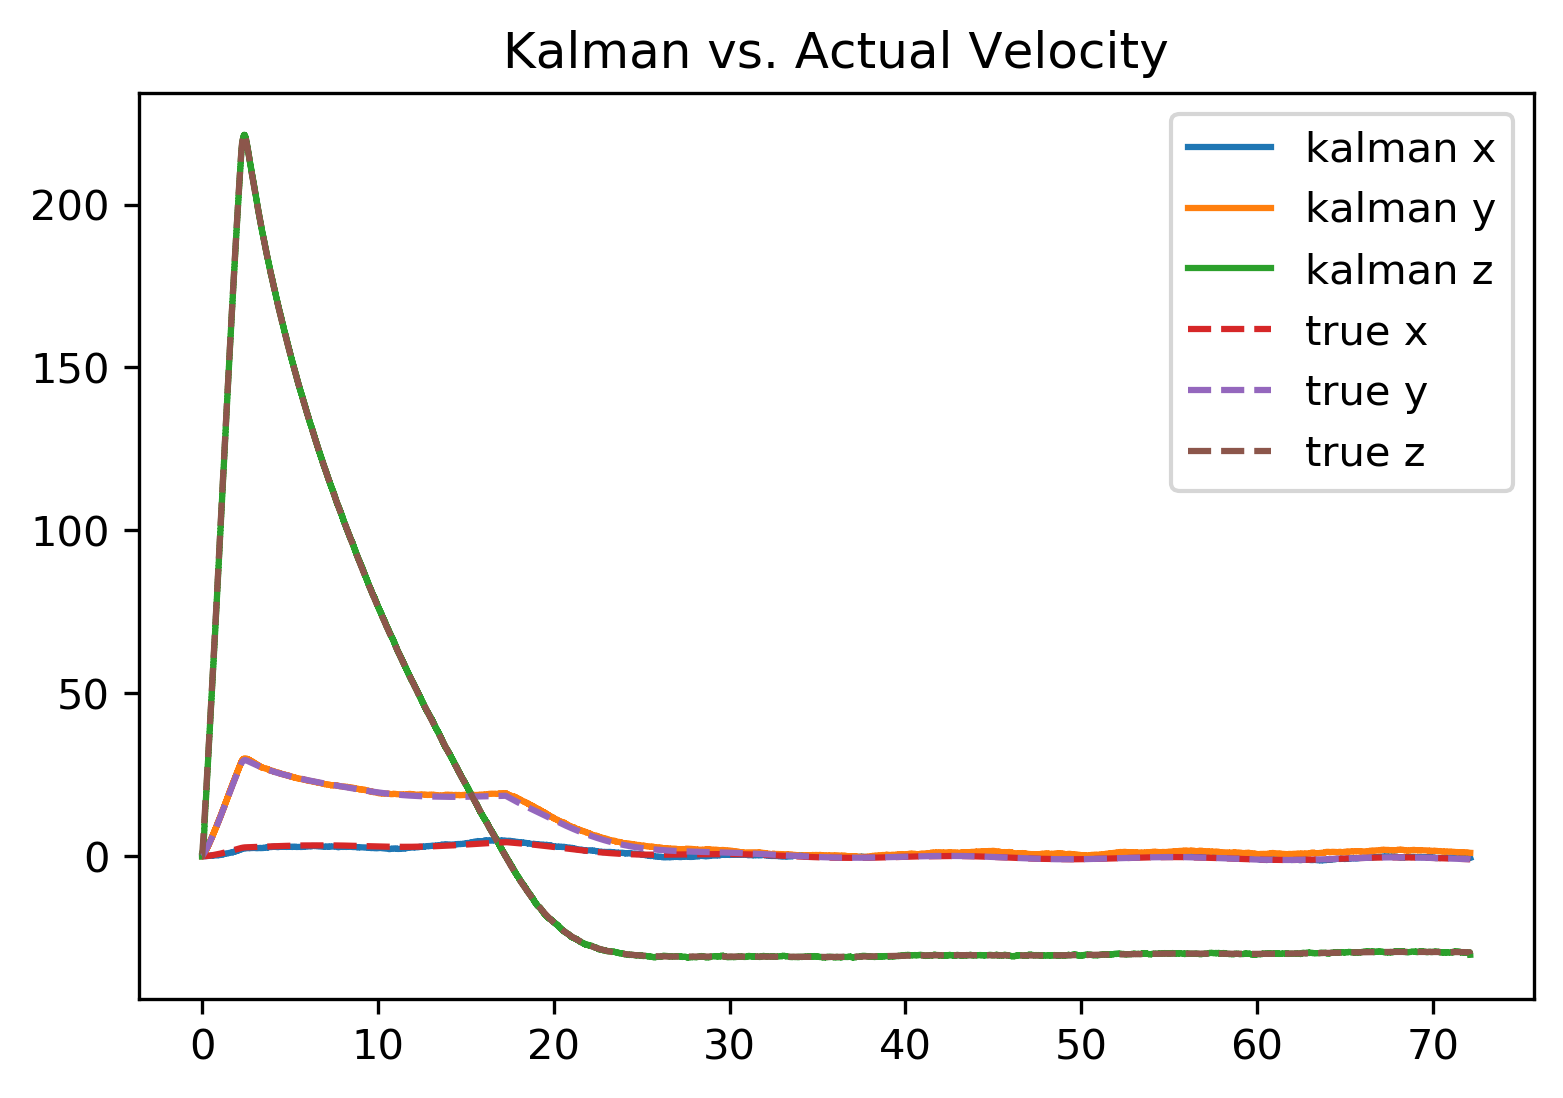

In [504]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,3:6]);
plt.plot(time,velocities,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. Actual Velocity');
plt.gcf().set_facecolor('white')

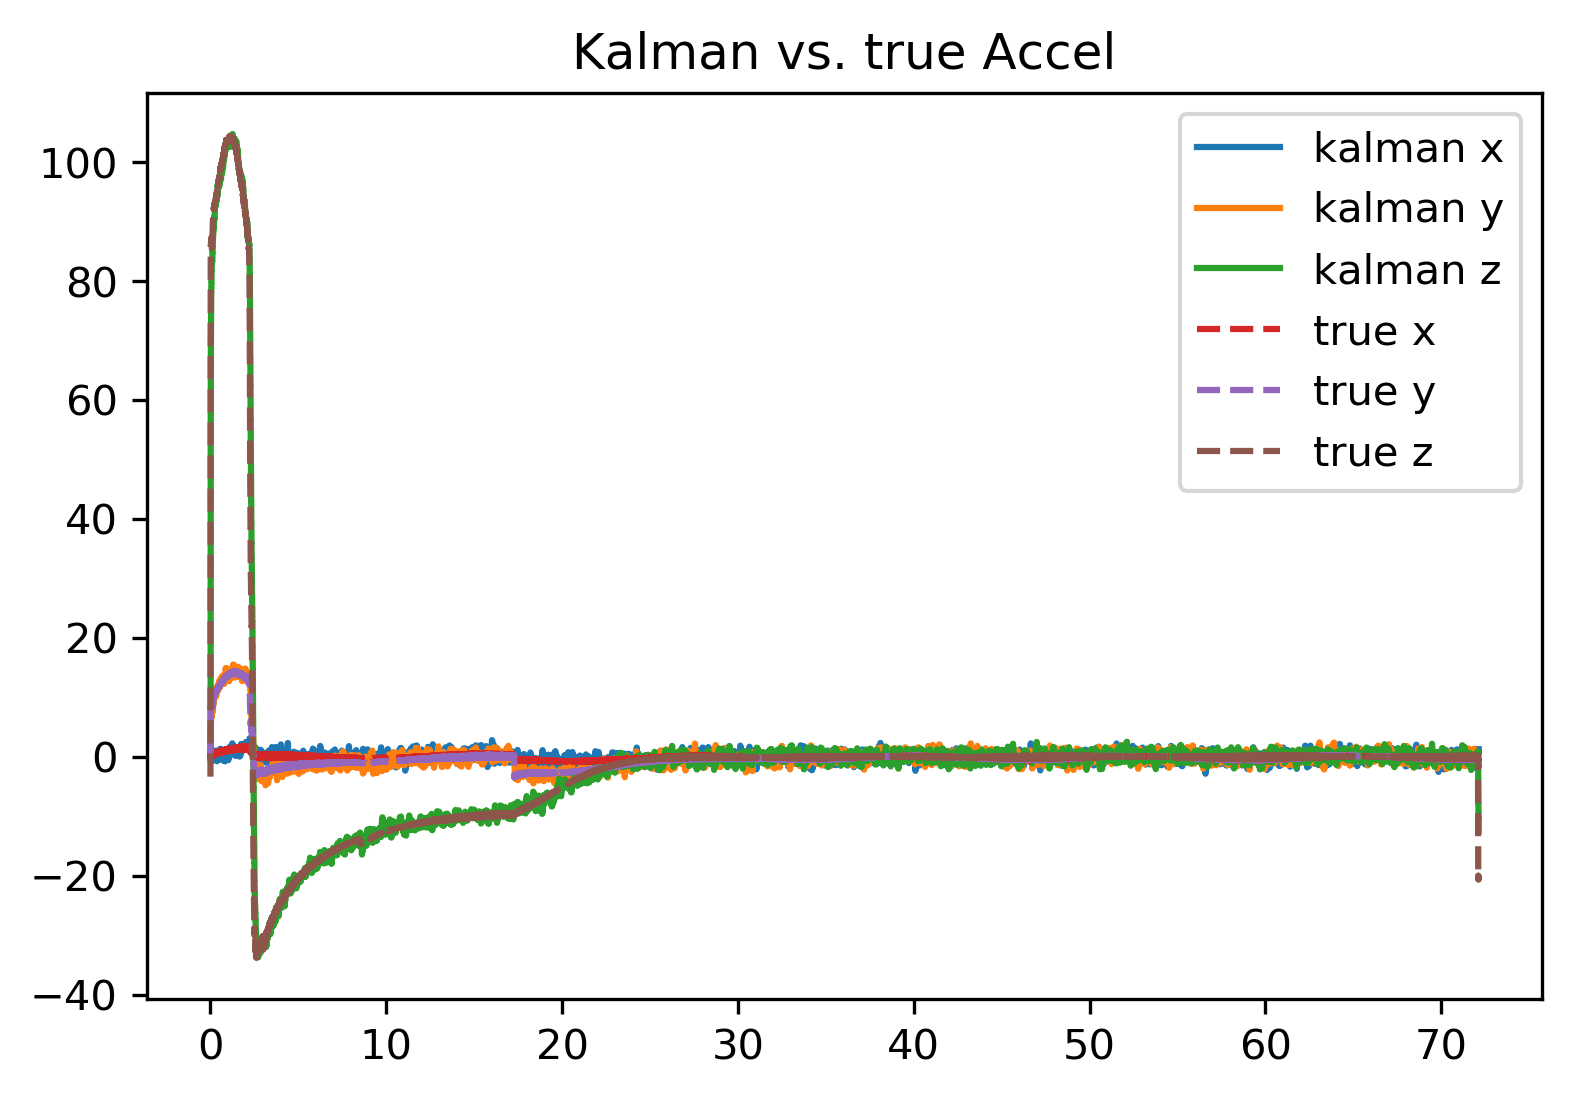

In [505]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, accelerations,'--');
plt.legend(['kalman x','kalman y','kalman z','true x','true y','true z'],loc='upper right')
plt.title('Kalman vs. true Accel');
#plt.xlim([0,10]);
plt.gcf().set_facecolor('white')

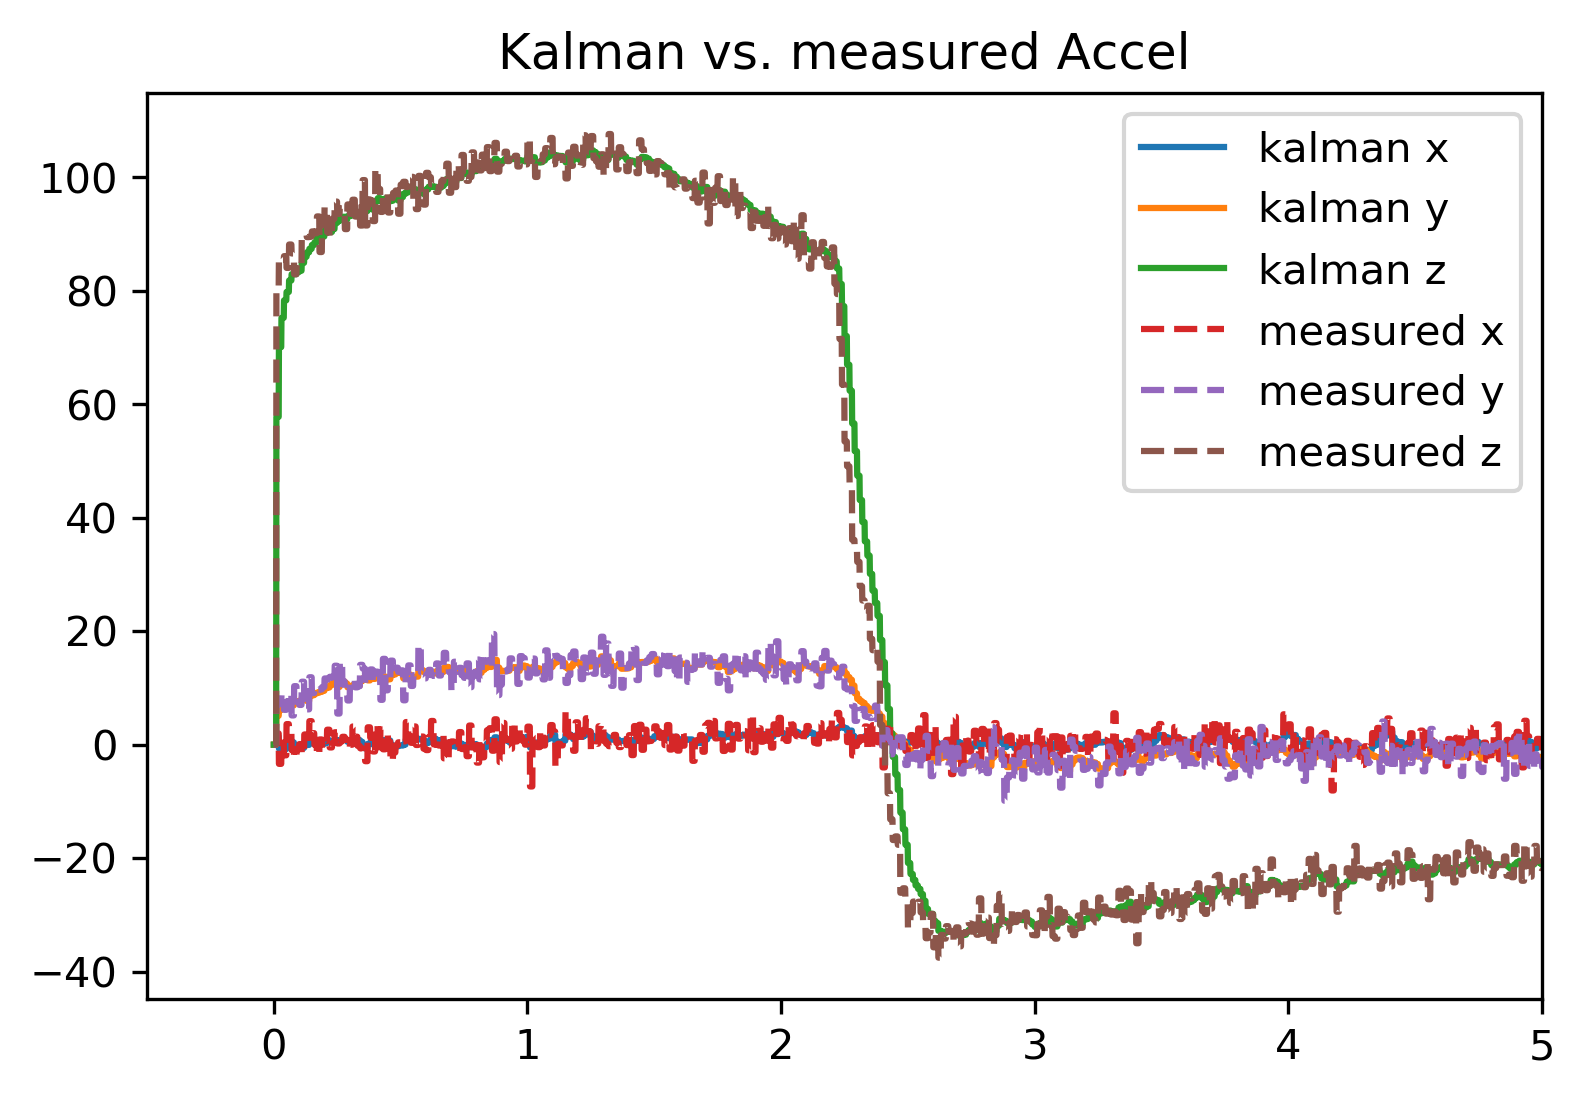

In [506]:
plt.figure(dpi=300)
plt.plot(time,stateVectors[:,6:9]);
plt.plot(time, measurements[:,1:4],'--');
plt.legend(['kalman x','kalman y','kalman z','measured x','measured y','measured z'],loc='upper right');
plt.title('Kalman vs. measured Accel');
plt.xlim([-.5,5]);
plt.gcf().set_facecolor('white')

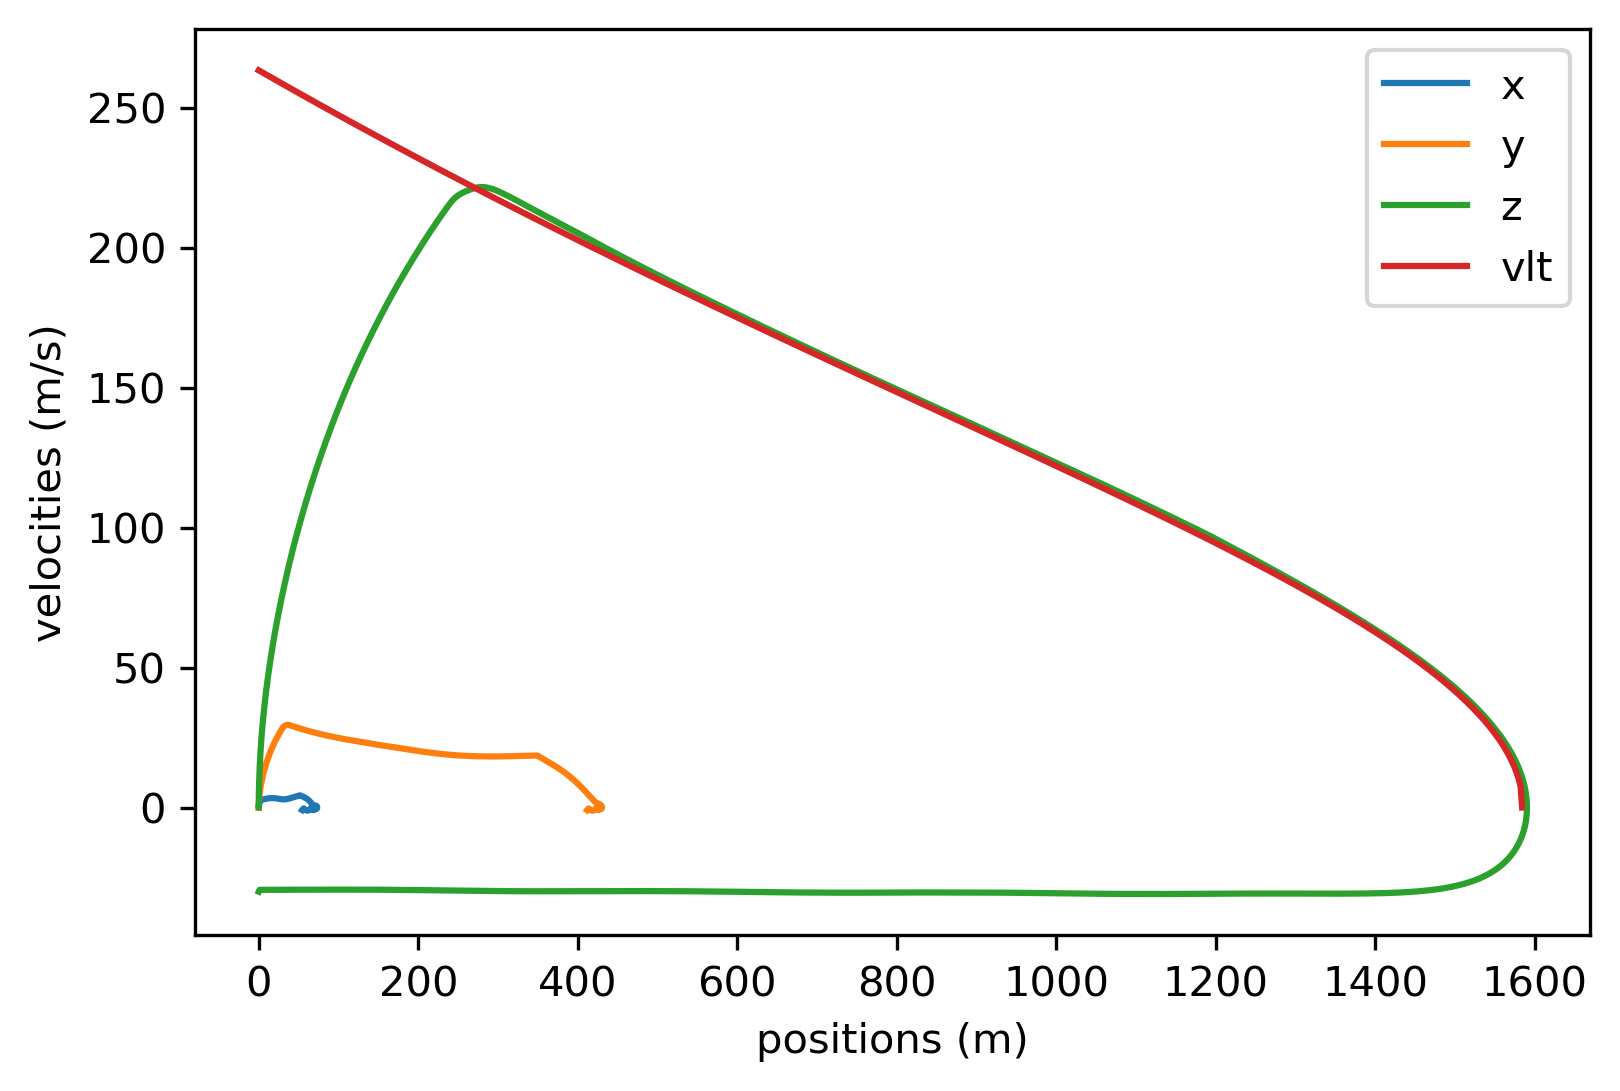

In [507]:
plt.figure(dpi=300)
plt.plot(positions,velocities);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('positions (m)')
plt.ylabel('velocities (m/s)')
plt.legend(['x','y','z','vlt'],loc='upper right');
plt.gcf().set_facecolor('white')

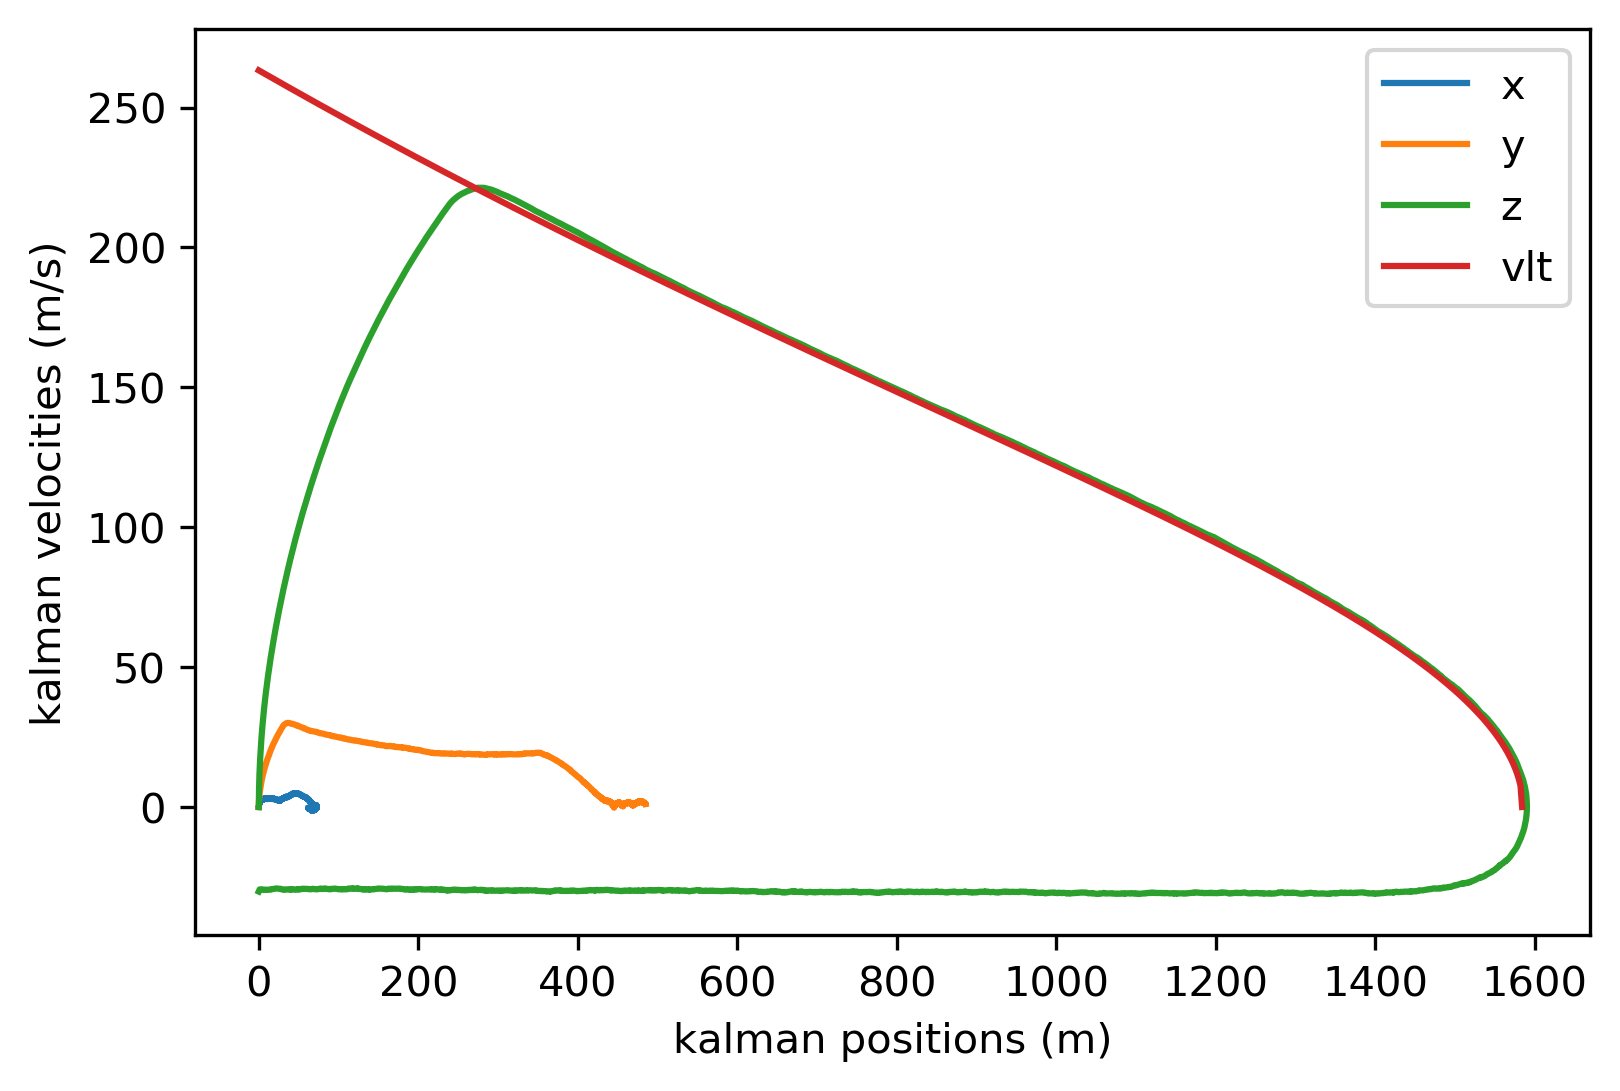

In [508]:
plt.figure(dpi=300)
plt.plot(stateVectors[:,0:3],stateVectors[:,3:6]);
plt.plot(velocityLookupTable[0],velocityLookupTable[1])
plt.xlabel('kalman positions (m)')
plt.ylabel('kalman velocities (m/s)')
plt.legend(['x','y','z','vlt'],loc='upper right');
plt.gcf().set_facecolor('white')

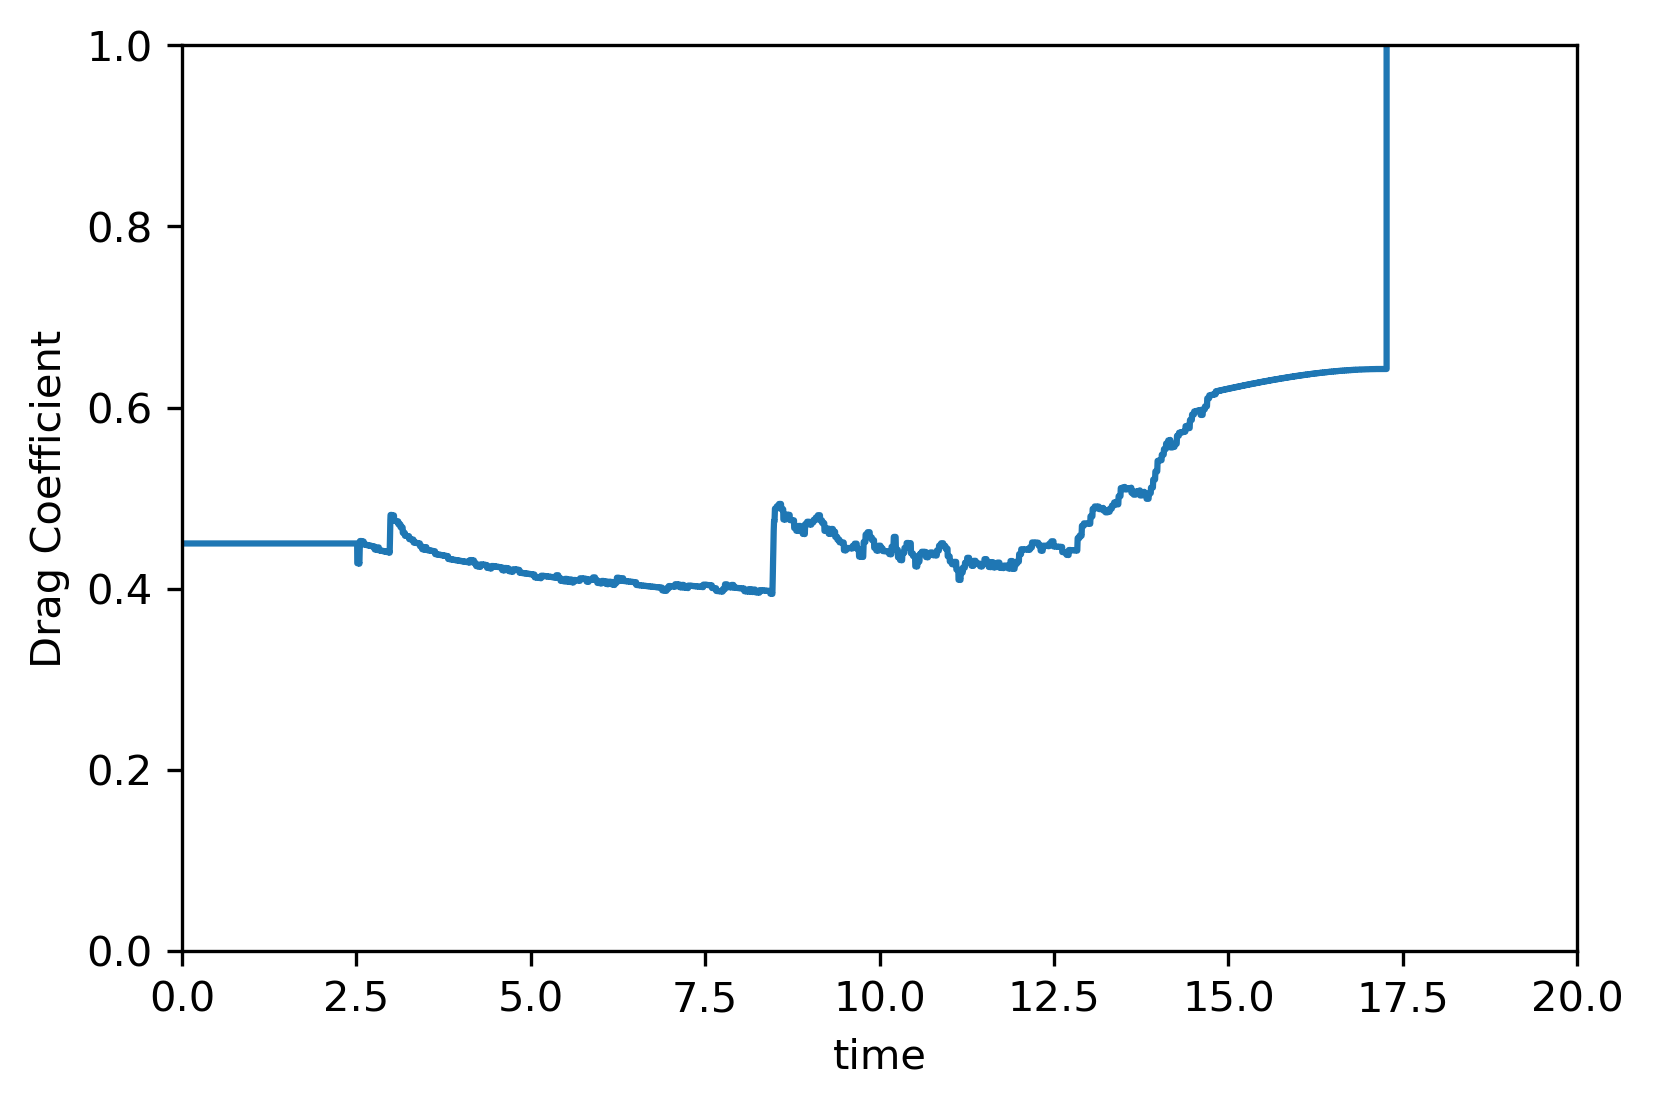

In [510]:
plt.figure(dpi=300)
plt.plot(time,dragCoefficient);
plt.ylim([0,1]);
plt.xlim([0,20]);
plt.xlabel('time')
plt.ylabel('Drag Coefficient');
plt.gcf().set_facecolor('white')

In [511]:
np.max(positions[:,2])

1590.0090251758788

In [512]:
np.max(positions[:,2])-targetAlt

6.009025175878833

In [513]:
PercentError = (np.max(positions[:,2])-targetAlt)/targetAlt*100
PercentError

0.37935764999235055

In [494]:
np.max(velocities[:,2])

221.63558759392166

In [495]:
positions[np.argmax(velocities[:,2]),2]

279.8329405574292

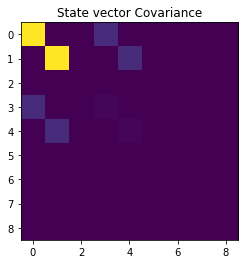

In [496]:
logPkalman = np.sqrt(Pkalman);
logPkalman[np.isneginf(logPkalman)] = 0
plt.imshow(logPkalman);
plt.title('State vector Covariance');